In [ ]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import glob
import pandas as pd

/home/alimina/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [ ]:
import utility_funcs as uf

In [ ]:
def train_input_fn(features, labels, feature_labels, batch_size=128):
    '''
    Description:
        This function is used in each step of training to prepare data
        in the proper format for the TF DNNCLASSIFIER
    Inputs:
        features: np array, features of the model
        labels: np array, the labels for the training set
        feature_labels: python list, label names for each of the features
        batch_size: num of rows to use in each iteration
    '''
    if type(features) != np.ndarray:
        features = np.array(features)
        
    num_cols = features.shape[1]
    assert len(feature_labels) == num_cols, "number of labels do not match the number of columns in the feature set"
    
    feat_dict = {}
    for ii,feat in enumerate(feature_labels):
        key = feature_labels[ii]
        feat_dict[key] = features[:,ii]
    dataset = tf.data.Dataset.from_tensor_slices((feat_dict,labels))
    
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    return dataset

def eval_input_fn(features, labels, feature_labels, batch_size=32):
    '''
    Description:
        This function is used for evaluating the performance of a model
    Inputs:
        features: np array, features of the model
        labels: np array, the labels for the training set
        feature_labels: python list, label names for each of the features
        batch_size: num of rows to use in each iteration
    '''
    if type(features) != np.ndarray:
        features = np.array(features)
        
    num_cols = features.shape[1]
    assert len(feature_labels) == num_cols, "number of labels do not match the number of columns in the feature set"
    
    feat_dict = {}
    for ii,feat in enumerate(feature_labels):
        key = feature_labels[ii]
        feat_dict[key] = features[:,ii]
    
    if labels is None:
        inputs = feat_dict
    else:
        inputs = (feat_dict, labels)

    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    dataset = dataset.batch(batch_size)

    return dataset

def make_feature_columns(features):
    '''
    Description:
        turns the list of feature names into a list understandable for TF.
        features must be all numeric
    Inputs:
        features: an iterable, containing the names of the feature set. 
            features must be all numeric
    '''
    my_feature_columns = []
    for key in features:
        my_feature_columns.append(tf.feature_column.numeric_column(key=key))
    
    return my_feature_columns

In [ ]:
def build_random_normal_dataset(df=None,N=100000,col_name='close'):
    '''
    Description:
        builds a random normal sequance and returns it as a pandas df,
        or a column added to an existing df
    Inputs:
        df: a pandas df, or none. If it's not None, the result will be 
            added as a column to this dataframe
        N:  the number of samples from a dataframe
        col_name: the column name to be used for storing the ramdom-normal
            sequence
    Output:
        a pandas df, either containing a single column named col_name (if df is None)
        or with an added column of name col_name (if df is provided)
    '''
    if df is None:
        df = pd.DataFrame()
    else:
        assert type(df) == pd.core.frame.DataFrame, "input df must be a pandas dataframe"
    
    if col_name in df.columns:
        print("WARNING: ", col_name, "already exists and is now over-written!")
    
    df[col_name] = np.random.normal(size=(N,)).astype(np.float32)

    return df

def shift_fwd_input_data(df,n=3,column="close"):
    '''
    Description:
        Given a dataframe, this function shifts the entries of the given column
        forward and writes them as new columns
    Inputs:
        df : a pandas dataframe
        n : the number of times to shift the column forward
        column: the name of the column to be shifted
    Output:
        a pandas df with "n" shifted columns named "column_+i" where "i" is
        in range(1,n+1)
    '''
    assert column in df.columns, column + " is not a column of the given dataframe"
    
    for ii in range(1,n+1):
        df[column + "_" + str(ii)] = df[column].shift(ii)
        
    return df

def shift_and_normalize(df,n=3,column='close'):
    '''
    Description:
        first normalizes a column and then shifts its contents forwd "n" times
        using the shift_fwd_input_data function
    Inputs:
        df : a pandas dataframe
        n : the number of times to shift the column forward
        column: the name of the column to be shifted
    Output:
        a pandas df with "n" normalized and shifted columns named "column_+i" 
        where "i" is in range(1,n+1)
    '''
    # CAUTION: FIRST NORMALIZE AND THEN SHIFT:
    df[column] = (df[column] - np.mean(df[column])) / np.std(df[column])
    df = shift_fwd_input_data(df,n=n,column=column)
    
        
    return df

def shift_normalize_mult30(df,n=3,column='close'):
    '''
    Description:
        first normalizes a column, then multiplies its content by
        30, and then shifts its contents forwd "n" times
        using the shift_fwd_input_data function [this is to test Gibbs]
    Inputs:
        df : a pandas dataframe
        n : the number of times to shift the column forward
        column: the name of the column to be shifted
    Output:
        a pandas df with "n" normalized, multiplied and shifted columns named 
        "column_+i" where "i" is in range(1,n+1)
    '''
    # CAUTION: FIRST NORMALIZE AND THEN SHIFT:
    df[column] = (df[column] - np.mean(df[column])) / np.std(df[column])
    df[column] = df[column]*30
    df = shift_fwd_input_data(df,n=n,column=column)
    
        
    return df
        
def add_truth(df,cond,col_name='truth'):
    '''
    Description:
        Given a rule, expressed in cond, this function adds a new column that
        is set to one when cond is True, and 0 otherwise
    Inputs:
        df : a pandas dataframe
        cond: the rule to use for classification
        col_name: the name to use for the newly added column
    '''
    df[col_name] = 0
    df.loc[cond,col_name] = 1
    
    
def split_to_train_and_test(df,train_ratio=None,train_size=None):
    '''
    Description:
        Split a dataframe to test and train sets based on a ratio, or size.
        Uses train_ratio if both train_ratio and train_size are provided
    Inputs:
        df : a pandas dataframe
        train_ratio : number in (0,1] to use for spliting df into train and test.
                 train set will contain a train_ratio of samples
        train_size : the number of samples to use in the training set
    Outputs:
        two pandas dataframes: (train_set, test_set)
    '''
    assert train_ratio != None or train_size != None,\
            "either the train ratio, or the train_size must have values"
    
    ell = len(df)
    if train_ratio != None:
        assert train_ratio <= 1, "train_ratio must be less than one"
        assert train_ratio > 0, "train ratio must be greater than zero"
        train_size = int(ell*train_ratio)
    
    assert train_size <= ell, "train_size must be smaller than the length of the dataframe"
    
    train = df[:train_size].values
    test = df[train_size:].values
    
    return train, test

In [ ]:
config = tf.estimator.RunConfig(save_summary_steps=5000,\
                                log_step_count_steps=5000)

<h3> random-normal samples, shallow NN</h3>

In [ ]:
np.random.seed(0)
N = 300000
# build the dataset from normal distribution:
df = build_random_normal_dataset(N=N)

# add shifted columns:
df = shift_fwd_input_data(df)
df.dropna(inplace=True)

# split dataframe:
features = list(df.columns)
train_ratio=0.8
train_x, test_x = split_to_train_and_test(df[features],train_ratio=train_ratio)

# add truth column:
cond = (df.close > df.close_1) & (df.close_1 > df.close_2) & (df.close_2 > df.close_3)
add_truth(df,cond)
train_y, test_y = split_to_train_and_test(df["truth"],train_ratio=train_ratio)

In [ ]:
accuracies = []
hidden_units =  [5]
num_steps = 50000

for i in range(50):
    # build the NN structure:
    my_feature_columns = make_feature_columns(features)
    classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,\
                                            hidden_units=hidden_units,\
                                            n_classes=2,\
                                            config = config)
    # train the model:
    classifier.train(input_fn=lambda: train_input_fn(train_x, train_y,\
                                                     batch_size=256,\
                                                     feature_labels=features),\
                     steps=num_steps)

    print("\n\n eval_results:")
    eval_result = classifier.evaluate(input_fn=lambda: eval_input_fn(test_x,\
                                                                     test_y,\
                                                                     feature_labels = features,\
                                                                     batch_size=256))
    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
    accuracies.append(eval_result['accuracy'])
    print("iteration {} done".format(i))
    uf.rm_tmp_folder(classifier.model_dir)

In [ ]:
for xx in accuracies:
    print(xx, end= ', ')

0.95675, 0.9939167, 0.9986333, 0.99865, 0.98656666, 0.99881667, 0.99841666, 0.9985333, 0.99755, 0.99855, 0.9985833, 0.99866664, 0.9984667, 0.99146664, 0.99778336, 0.99868333, 0.99831665, 0.99868333, 0.99155, 0.99826664, 0.99873334, 0.99865, 0.99871665, 0.9923667, 0.99841666, 0.9985833, 0.99871665, 0.99158335, 0.9984, 0.9572, 0.99868333, 0.9987, 0.9975833, 0.99876666, 0.99865, 0.9984, 0.99813336, 0.95696664, 0.99865, 0.9983, 0.9845667, 0.99865, 0.9985667, 0.99855, 0.9985, 0.9986, 0.9916667, 0.99878335, 0.99866664, 0.99873334, 

0.9947266650000001 0.01005257103223613


Text(0,0.5,'frequency')

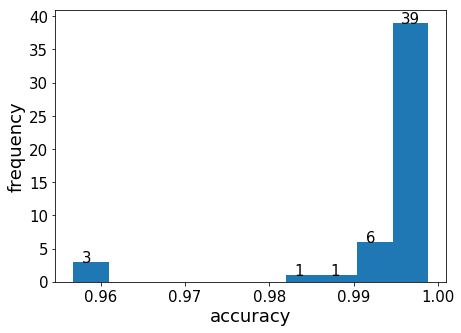

In [ ]:
plt.figure(figsize=(7,5))
print(np.mean(accuracies),np.std(accuracies))

plt.tick_params(axis='both', which='major', labelsize=15)
arr = plt.hist(accuracies)
for i in range(len(arr[1])-1):
    if int(arr[0][i]) != 0:
        plt.text(float(arr[1][i])+0.001,arr[0][i],str(int(arr[0][i])),fontsize=15)
        
plt.xlabel("accuracy",fontsize = 18)
plt.ylabel("frequency",fontsize = 18)

<h3> random-normal samples, deeper NN </h3>

In [ ]:
hidden_units =  [5,5,5,4]
num_steps = 50000
accuracies_2 = []

for i in range(50):
    # build the NN structure:
    my_feature_columns = make_feature_columns(features)
    
    classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,\
                                            hidden_units=hidden_units,\
                                            n_classes=2,\
                                            config = config)

    # train the model:
    classifier.train(input_fn=lambda: train_input_fn(train_x, train_y,\
                                                     batch_size=256,\
                                                     feature_labels=features),\
                     steps=num_steps)

    print("\n\n eval_results:")
    eval_result = classifier.evaluate(input_fn=lambda: eval_input_fn(test_x,\
                                                                     test_y,\
                                                                     feature_labels = features,\
                                                                     batch_size=256))
    # 
    classifier.config.session_config.Clear()
    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
    accuracies_2.append(eval_result['accuracy'])
    print("iteration {} done".format(i))
    uf.rm_tmp_folder(classifier.model_dir)

In [ ]:
# print accuracies so we won't need to rerun the expriment again:
for xx in accuracies_2:
    print(xx, end= ', ')

0.99948335, 0.9995667, 0.99986666, 0.99983335, 0.99978334, 0.9998, 0.99976665, 0.99975, 0.99978334, 0.99986666, 0.99981666, 0.99976665, 0.9995667, 0.9996667, 0.99953336, 0.99981666, 0.99985, 0.99976665, 0.95696664, 0.9999, 0.9996833, 0.95696664, 0.9997333, 0.9996833, 0.99983335, 0.9998, 0.9998, 0.99978334, 0.9999, 0.99976665, 0.9999167, 0.99975, 0.9999, 0.9996167, 0.9998, 0.99988335, 0.9996667, 0.99986666, 0.99946666, 0.9997, 0.99986666, 0.9995667, 0.95696664, 0.99976665, 0.99946666, 0.99978334, 0.9991, 0.9993, 0.99951667, 0.9999, 

0.9971580007999999 0.010155457124499098


Text(0,0.5,'frequency')

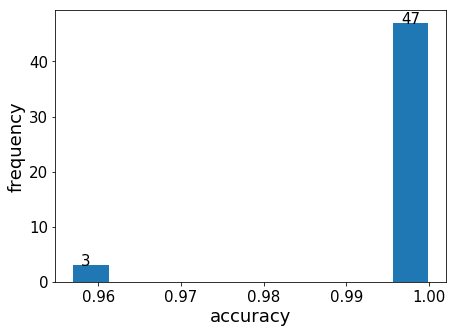

In [ ]:
plt.figure(figsize=(7,5))
plt.tick_params(axis='both', which='major', labelsize=15)

print(np.mean(accuracies_2),np.std(accuracies_2))
arr = plt.hist(accuracies_2)
for i in range(len(arr[1])-1):
    if int(arr[0][i]) != 0:
        plt.text(float(arr[1][i])+0.001,arr[0][i],str(int(arr[0][i])),fontsize=15)
        
plt.xlabel("accuracy",fontsize = 18)
plt.ylabel("frequency",fontsize = 18)

<h3> random-normal samples, Deep and tall NN </h3>

In [ ]:
hidden_units =  [60,60,30,30,5]
num_steps = 50000
accuracies_3 = []

for i in range(50):
    # build the NN structure:
    my_feature_columns = make_feature_columns(features)
    
    classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,\
                                            hidden_units=hidden_units,\
                                            n_classes=2,\
                                            config = config)

    # train the model:
    classifier.train(input_fn=lambda: train_input_fn(train_x, train_y,\
                                                     batch_size=256,\
                                                     feature_labels=features),\
                     steps=num_steps)

    print("\n\n eval_results:")
    eval_result = classifier.evaluate(input_fn=lambda: eval_input_fn(test_x,\
                                                                     test_y,\
                                                                     feature_labels = features,\
                                                                     batch_size=256))
    # 
    classifier.config.session_config.Clear()
    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
    accuracies_3.append(eval_result['accuracy'])
    print("iteration {} done".format(i))
    uf.rm_tmp_folder(classifier.model_dir)

In [ ]:
for xx in accuracies_3:
    print(xx, end= ', ')

0.99948335, 0.99941665, 0.99953336, 0.9996167, 0.99971664, 0.99945, 0.99953336, 0.99978334, 0.9995, 0.99953336, 0.9996833, 0.99955, 0.99946666, 0.99953336, 0.9996333, 0.99943334, 0.99951667, 0.99955, 0.9995667, 0.9995833, 0.99965, 0.9995833, 0.99955, 0.99935, 0.99953336, 0.99938333, 0.99971664, 0.9995833, 0.9998, 0.95696664, 0.9995833, 0.99965, 0.9996333, 0.9995, 0.99936664, 0.9995833, 0.9995667, 0.9995, 0.99965, 0.9996167, 0.99916667, 0.99951667, 0.9996333, 0.9996333, 0.99943334, 0.9995833, 0.9995833, 0.99965, 0.99936664, 0.9995833, 

0.9986999944 0.005962973867538635


Text(0,0.5,'frequency')

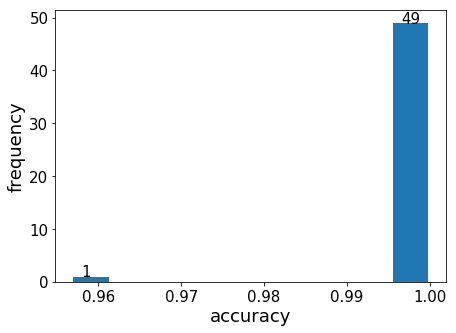

In [ ]:
plt.figure(figsize=(7,5))
plt.tick_params(axis='both', which='major', labelsize=15)

print(np.mean(accuracies_3),np.std(accuracies_3))
arr = plt.hist(accuracies_3)
for i in range(len(arr[1])-1):
    if int(arr[0][i]) != 0:
        plt.text(float(arr[1][i])+0.001,arr[0][i],str(int(arr[0][i])),fontsize=15)
        
plt.xlabel("accuracy",fontsize = 18)
plt.ylabel("frequency",fontsize = 18)

<h3> Market data, single currency: </h3>

In [ ]:
# read market data:
file_list = glob.glob("./data/*")

df = uf.read_many_files(file_list[:1],add_to_each_df_func=shift_fwd_input_data)
print(len(df))

# drop nan:
df.dropna(inplace=True)

# split dataframe:
features = ['close','close_1','close_2','close_3']
train_ratio=0.8
train_x, test_x = split_to_train_and_test(df[features],train_ratio=train_ratio)

# add truth column:
cond = (df.close > df.close_1) & (df.close_1 > df.close_2) & (df.close_2 > df.close_3)
add_truth(df,cond)
train_y, test_y = split_to_train_and_test(df["truth"],train_ratio=train_ratio)

75039


In [ ]:
hidden_units =  [60,60,30,30,5]
num_steps = 50000
accuracies_4 = []

for i in range(20):
    # build the NN structure:
    my_feature_columns = make_feature_columns(features)
    
    classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,\
                                            hidden_units=hidden_units,\
                                            n_classes=2,\
                                            config = config)

    # train the model:
    classifier.train(input_fn=lambda: train_input_fn(train_x, train_y,\
                                                     batch_size=256,\
                                                     feature_labels=features),\
                     steps=num_steps)

    print("\n\n eval_results:")
    eval_result = classifier.evaluate(input_fn=lambda: eval_input_fn(test_x,\
                                                                     test_y,\
                                                                     feature_labels = features,\
                                                                     batch_size=256))
    
    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
    accuracies_4.append(eval_result['accuracy'])
    print("iteration {} done".format(i))
    uf.rm_tmp_folder(classifier.model_dir)

In [ ]:
for xx in accuracies_4:
    print(xx,end=", ")

0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 0.89085823, 

<h3> Market data, single currency, normalized: </h3>

In [ ]:
# read market data:
file_list = glob.glob("./data/*")

df = uf.read_many_files(file_list[:1],add_to_each_df_func=shift_and_normalize)
print(len(df))

# drop nan:
df.dropna(inplace=True)

# split dataframe:
features = ['close','close_1','close_2','close_3']
train_ratio=0.8
train_x, test_x = split_to_train_and_test(df[features],train_ratio=train_ratio)

# add truth column:
cond = (df.close > df.close_1) & (df.close_1 > df.close_2) & (df.close_2 > df.close_3)
add_truth(df,cond)
train_y, test_y = split_to_train_and_test(df["truth"],train_ratio=train_ratio)

75039


In [ ]:
hidden_units =  [60,60,30,30,5]
num_steps = 50000
accuracies_5 = []

for i in range(50):
    # build the NN structure:
    my_feature_columns = make_feature_columns(features)
    
    classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,\
                                            hidden_units=hidden_units,\
                                            n_classes=2,\
                                            config = config)

    # train the model:
    classifier.train(input_fn=lambda: train_input_fn(train_x, train_y,\
                                                     batch_size=256,\
                                                     feature_labels=features),\
                     steps=num_steps)

    print("\n\n eval_results:")
    eval_result = classifier.evaluate(input_fn=lambda: eval_input_fn(test_x,\
                                                                     test_y,\
                                                                     feature_labels = features,\
                                                                     batch_size=256))
    
    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
    accuracies_5.append(eval_result['accuracy'])
    print("iteration {} done".format(i))
    uf.rm_tmp_folder(classifier.model_dir)

In [ ]:
for xx in accuracies_5:
    print(xx,end=", ")

0.96801704, 0.95682305, 0.9716818, 0.89085823, 0.9505597, 0.9642191, 0.9503598, 0.9732809, 0.961887, 0.89085823, 0.9666178, 0.95629, 0.96068764, 0.9438966, 0.9646855, 0.9807436, 0.89085823, 0.9807436, 0.97961086, 0.93243605, 0.97694564, 0.9751466, 0.9695496, 0.98087686, 0.9770123, 0.944363, 0.9303038, 0.97721213, 0.961887, 0.9520256, 0.9688833, 0.97428036, 0.95902187, 0.96348614, 0.9658182, 0.9780117, 0.9754797, 0.96728414, 0.94996, 0.9807436, 0.93010396, 0.95615673, 0.95275855, 0.9717484, 0.9617537, 0.9680837, 0.97974414, 0.9554904, 0.98087686, 0.94149786, 

0.9592324 0.021864932


Text(0,0.5,'frequency')

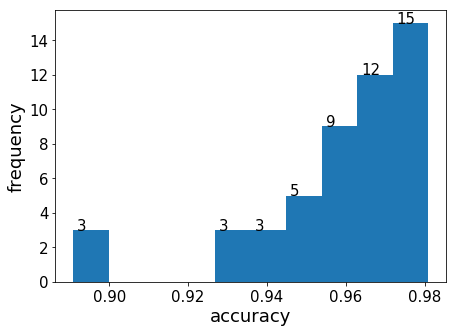

In [ ]:
plt.figure(figsize=(7,5))
plt.tick_params(axis='both', which='major', labelsize=15)

print(np.mean(accuracies_5),np.std(accuracies_5))
arr = plt.hist(accuracies_5)
for i in range(len(arr[1])-1):
    if int(arr[0][i]) != 0:
        plt.text(float(arr[1][i])+0.001,arr[0][i],str(int(arr[0][i])),fontsize=15)
        
plt.xlabel("accuracy",fontsize = 18)
plt.ylabel("frequency",fontsize = 18)

<h3> Market data, 10 currencies, normalized: </h3>

In [ ]:
# read market data:
file_list = glob.glob("./data/*")

df = uf.read_many_files(file_list,add_to_each_df_func=shift_and_normalize)
print(len(df))

# drop nan:
df.dropna(inplace=True)

# split dataframe:
features = ['close','close_1','close_2','close_3']
train_ratio=0.8
train_x, test_x = split_to_train_and_test(df[features],train_ratio=train_ratio)

# add truth column:
cond = (df.close > df.close_1) & (df.close_1 > df.close_2) & (df.close_2 > df.close_3)
add_truth(df,cond)
train_y, test_y = split_to_train_and_test(df["truth"],train_ratio=train_ratio)

751533


In [ ]:
hidden_units =  [60,60,30,30,5]
num_steps = 200000
accuracies_6 = []

for i in range(30):
    # build the NN structure:
    my_feature_columns = make_feature_columns(features)
    
    classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,\
                                            hidden_units=hidden_units,\
                                            n_classes=2,\
                                            config = config)

    # train the model:
    classifier.train(input_fn=lambda: train_input_fn(train_x, train_y,\
                                                     batch_size=256,\
                                                     feature_labels=features),\
                     steps=num_steps)

    print("\n\n eval_results:")
    eval_result = classifier.evaluate(input_fn=lambda: eval_input_fn(test_x,\
                                                                     test_y,\
                                                                     feature_labels = features,\
                                                                     batch_size=256))
    
    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
    accuracies_6.append(eval_result['accuracy'])
    print("iteration {} done".format(i))
    uf.rm_tmp_folder(classifier.model_dir)

In [ ]:
for xx in accuracies_6:
    print(xx,end=", ")

0.9616741, 0.9794362, 0.9737728, 0.96721107, 0.963431, 0.94923604, 0.9491961, 0.9581936, 0.9627855, 0.9566297, 0.8957834, 0.9439852, 0.9591652, 0.9554451, 0.9785378, 0.94403183, 0.8957834, 0.9688814, 0.96013016, 0.94857717, 0.92438644, 0.9591253, 0.9583999, 0.96499497, 0.9471863, 0.94863707, 0.9664657, 0.9597043, 0.95881915, 0.9690478, 

0.95428836 0.01911271


Text(0,0.5,'frequency')

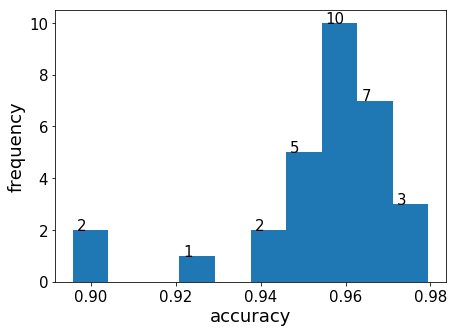

In [ ]:
plt.figure(figsize=(7,5))
plt.tick_params(axis='both', which='major', labelsize=15)

print(np.mean(accuracies_6),np.std(accuracies_6))
arr = plt.hist(accuracies_6)
for i in range(len(arr[1])-1):
    if int(arr[0][i]) != 0:
        plt.text(float(arr[1][i])+0.001,arr[0][i],str(int(arr[0][i])),fontsize=15)
        
plt.xlabel("accuracy",fontsize = 18)
plt.ylabel("frequency",fontsize = 18)

<h3> Market data, single currency, normlaized and multiplied by 30: </h3>

In [ ]:
# read market data:
file_list = glob.glob("./data/*")

df = uf.read_many_files(file_list[:1],add_to_each_df_func=shift_normalize_mult30)
print(len(df))

# drop nan:
df.dropna(inplace=True)

# split dataframe:
features = ['close','close_1','close_2','close_3']
train_ratio=0.8
train_x, test_x = split_to_train_and_test(df[features],train_ratio=train_ratio)

# add truth column:
cond = (df.close > df.close_1) & (df.close_1 > df.close_2) & (df.close_2 > df.close_3)
add_truth(df,cond)
train_y, test_y = split_to_train_and_test(df["truth"],train_ratio=train_ratio)

75039


In [ ]:
hidden_units =  [60,60,30,30,5]
num_steps = 50000
accuracies_7 = []

for i in range(50):
    # build the NN structure:
    my_feature_columns = make_feature_columns(features)
    
    classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,\
                                            hidden_units=hidden_units,\
                                            n_classes=2,\
                                            config = config)

    # train the model:
    classifier.train(input_fn=lambda: train_input_fn(train_x, train_y,\
                                                     batch_size=256,\
                                                     feature_labels=features),\
                     steps=num_steps)

    print("\n\n eval_results:")
    eval_result = classifier.evaluate(input_fn=lambda: eval_input_fn(test_x,\
                                                                     test_y,\
                                                                     feature_labels = features,\
                                                                     batch_size=256))
    
    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
    accuracies_7.append(eval_result['accuracy'])
    print("iteration {} done".format(i))
    uf.rm_tmp_folder(classifier.model_dir)

In [ ]:
for xx in accuracies_7:
    print(xx,end=", ")

0.9492271, 0.9826759, 0.9493604, 0.9754797, 0.98380864, 0.89085823, 0.98634064, 0.96961623, 0.98254263, 0.9887393, 0.9880064, 0.9754797, 0.95449096, 0.97727877, 0.9848747, 0.96755064, 0.9656183, 0.98380864, 0.9658182, 0.9564232, 0.9620869, 0.98833954, 0.9838753, 0.89085823, 0.9578225, 0.9665512, 0.98334223, 0.9848747, 0.983742, 0.9846748, 0.99027187, 0.95002663, 0.9856743, 0.9822095, 0.9816098, 0.98634064, 0.9836087, 0.97721213, 0.9676839, 0.89085823, 0.96088755, 0.9800107, 0.89085823, 0.9920043, 0.9845416, 0.9881396, 0.97761196, 0.89085823, 0.9884062, 0.9820762, 

0.96790105 0.028125696


Text(0,0.5,'frequency')

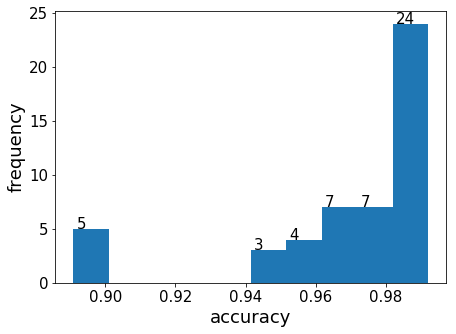

In [ ]:
plt.figure(figsize=(7,5))
plt.tick_params(axis='both', which='major', labelsize=15)

print(np.mean(accuracies_7),np.std(accuracies_7))
arr = plt.hist(accuracies_7)
for i in range(len(arr[1])-1):
    if int(arr[0][i]) != 0:
        plt.text(float(arr[1][i])+0.001,arr[0][i],str(int(arr[0][i])),fontsize=15)
        
plt.xlabel("accuracy",fontsize = 18)
plt.ylabel("frequency",fontsize = 18)

<h3> full market data, close difference instead of closing price: </h3>

In [ ]:
# read market data:
file_list = glob.glob("./data/*")

df = uf.read_many_files(file_list,add_to_each_df_func=shift_and_normalize)
print(len(df))

# drop nans, add diff cols:
df.dropna(inplace=True)
df['diff_1'] = df.close - df.close_1
df['diff_2'] = df.close_1 - df.close_2
df['diff_3'] = df.close_2 - df.close_3

# split dataframe:
features = ['diff_1','diff_2','diff_3']
train_ratio=0.8
train_x, test_x = split_to_train_and_test(df[features],train_ratio=train_ratio)

# add truth column:
cond = (df.close > df.close_1) & (df.close_1 > df.close_2) & (df.close_2 > df.close_3)
add_truth(df,cond)
train_y, test_y = split_to_train_and_test(df["truth"],train_ratio=train_ratio)

751533


In [ ]:
np.random.seed(0)
hidden_units =  [5,5]
num_steps = 200000
accuracies_8 = []

for i in range(30):
    # build the NN structure:
    my_feature_columns = make_feature_columns(features)
    
    classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,\
                                            hidden_units=hidden_units,\
                                            n_classes=2,\
                                            config = config)

    # train the model:
    classifier.train(input_fn=lambda: train_input_fn(train_x, train_y,\
                                                     batch_size=256,\
                                                     feature_labels=features),\
                     steps=num_steps)

    print("\n\n eval_results:")
    eval_result = classifier.evaluate(input_fn=lambda: eval_input_fn(test_x,\
                                                                     test_y,\
                                                                     feature_labels = features,\
                                                                     batch_size=256))
    
    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
    accuracies_8.append(eval_result['accuracy'])
    print("iteration {} done".format(i))
    uf.rm_tmp_folder(classifier.model_dir)

In [ ]:
for xx in accuracies_8:
    print(xx,end=", ")

0.9986224, 0.99859583, 0.9989951, 0.99886864, 0.9988021, 0.99846935, 0.99886864, 0.9985492, 0.9986091, 0.925205, 0.99827635, 0.99853593, 0.9974645, 0.9929724, 0.9726548, 0.99840283, 0.9981832, 0.9987688, 0.9987023, 0.9987755, 0.997318, 0.9656338, 0.92626977, 0.9259903, 0.9981632, 0.9981699, 0.99879545, 0.99880874, 0.9905433, 0.99873555, 

0.98882496 0.022274656


Text(0,0.5,'frequency')

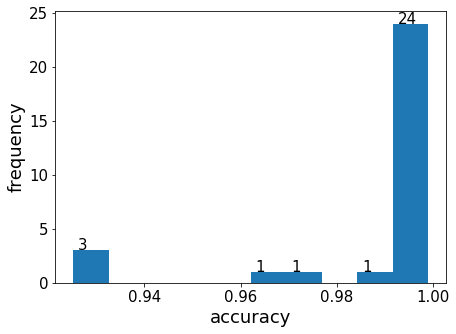

In [ ]:
plt.figure(figsize=(7,5))
plt.tick_params(axis='both', which='major', labelsize=15)

print(np.mean(accuracies_8),np.std(accuracies_8))
arr = plt.hist(accuracies_8)
for i in range(len(arr[1])-1):
    if int(arr[0][i]) != 0:
        plt.text(float(arr[1][i])+0.001,arr[0][i],str(int(arr[0][i])),fontsize=15)
        
plt.xlabel("accuracy",fontsize = 18)
plt.ylabel("frequency",fontsize = 18)

<h3> single currency, close difference instead of closing price: </h3>

In [ ]:
# read market data:
file_list = glob.glob("./data/*")

df = uf.read_many_files(file_list[:1],add_to_each_df_func=shift_and_normalize)
print(len(df))

# drop nans, add diff cols:
df.dropna(inplace=True)
df['diff_1'] = df.close - df.close_1
df['diff_2'] = df.close_1 - df.close_2
df['diff_3'] = df.close_2 - df.close_3

# split dataframe:
features = ['diff_1','diff_2','diff_3']
train_ratio=0.8
train_x, test_x = split_to_train_and_test(df[features],train_ratio=train_ratio)

# add truth column:
cond = (df.close > df.close_1) & (df.close_1 > df.close_2) & (df.close_2 > df.close_3)
add_truth(df,cond)
train_y, test_y = split_to_train_and_test(df["truth"],train_ratio=train_ratio)

75039


In [ ]:
np.random.seed(0)
hidden_units =  [5,5]
num_steps = 50000
accuracies_9 = []

for i in range(30):
    # build the NN structure:
    my_feature_columns = make_feature_columns(features)
    
    classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,\
                                            hidden_units=hidden_units,\
                                            n_classes=2,\
                                            config = config)

    # train the model:
    classifier.train(input_fn=lambda: train_input_fn(train_x, train_y,\
                                                     batch_size=256,\
                                                     feature_labels=features),\
                     steps=num_steps)

    print("\n\n eval_results:")
    eval_result = classifier.evaluate(input_fn=lambda: eval_input_fn(test_x,\
                                                                     test_y,\
                                                                     feature_labels = features,\
                                                                     batch_size=256))
    
    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
    accuracies_9.append(eval_result['accuracy'])
    print("iteration {} done".format(i))
    uf.rm_tmp_folder(classifier.model_dir)

In [ ]:
for xx in accuracies_9:
    print(xx,end=", ")

0.98900586, 0.99260396, 0.9945362, 0.9968683, 0.9297041, 0.99553573, 0.9948694, 0.9948028, 0.99553573, 0.9978012, 0.99600214, 0.99793446, 0.9984675, 0.9970016, 0.9880064, 0.9909382, 0.99227077, 0.97488004, 0.9888726, 0.9950693, 0.99586886, 0.9950027, 0.9942697, 0.9940698, 0.9960688, 0.99027187, 0.89005864, 0.9976013, 0.9881396, 0.9871402, 

0.98764 0.021899085


Text(0,0.5,'frequency')

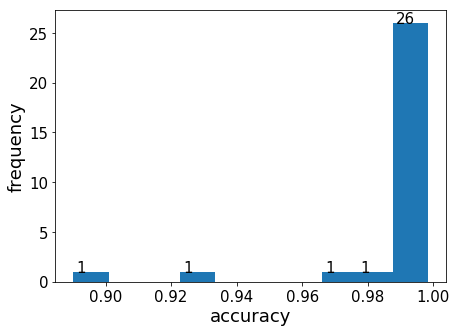

In [ ]:
plt.figure(figsize=(7,5))
plt.tick_params(axis='both', which='major', labelsize=15)

print(np.mean(accuracies_9),np.std(accuracies_9))
arr = plt.hist(accuracies_9)
for i in range(len(arr[1])-1):
    if int(arr[0][i]) != 0:
        plt.text(float(arr[1][i])+0.001,arr[0][i],str(int(arr[0][i])),fontsize=15)
        
plt.xlabel("accuracy",fontsize = 18)
plt.ylabel("frequency",fontsize = 18)

<h3> Three independent normal cols, truth: all cols > 0 : </h3>

In [ ]:
np.random.seed(0)
N = 300000
# build the dataset from normal distribution:
df = build_random_normal_dataset(N=N)
df = build_random_normal_dataset(df=df,N=N,col_name='close_1')
df = build_random_normal_dataset(df,N=N,col_name='close_2')

# split dataframe:
features = list(df.columns)
train_ratio=0.8
train_x, test_x = split_to_train_and_test(df[features],train_ratio=train_ratio)

# add truth column:
cond = (df.close > 0) & (df.close_1 > 0) & (df.close_2 > 0)
add_truth(df,cond)
train_y, test_y = split_to_train_and_test(df["truth"],train_ratio=train_ratio)

In [ ]:
hidden_units =  [5,5]
num_steps = 10000

# build the NN structure:
my_feature_columns = make_feature_columns(features)

classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns,\
                                        hidden_units=hidden_units,\
                                        n_classes=2)

# train the model:
classifier.train(input_fn=lambda: train_input_fn(train_x, train_y,\
                                                 batch_size=256,\
                                                 feature_labels=features),\
                 steps=num_steps)

print("\n\n eval_results:")
eval_result = classifier.evaluate(input_fn=lambda: eval_input_fn(test_x,\
                                                                 test_y,\
                                                                 feature_labels = features,\
                                                                 batch_size=256))
# 
classifier.config.session_config.Clear()
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))